In [1]:
#from bs4 import BeautifulSoup
#from urllib.request import urlopen
import requests
from io import StringIO
import csv
import pandas as pd
from itertools import product
import seaborn as sns
import numpy as np

D:\Anaconda\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def feature_engineering(dataframe_elo_score,dataframe_game_results,date_bounds=['2018',"2022-11-20"],
                        tournaments_list=['Friendly', 'FIFA World Cup qualification', 'UEFA Nations League',
       'UEFA Euro qualification', 'African Cup of Nations qualification',
       'CONCACAF Nations League', 'African Cup of Nations',
       'African Nations Championship', 'COSAFA Cup',
       'AFC Asian Cup qualification', 'Gold Cup', 'FIFA World Cup',
       'Copa América', 'UEFA Euro', 'AFC Asian Cup',
       'CONIFA World Football Cup', 'Island Games',
       'CONCACAF Nations League qualification',
       'African Nations Championship qualification', 'AFF Championship',
       'CONIFA European Football Cup', 'CECAFA Cup', 'EAFF Championship',
       'CFU Caribbean Cup qualification', 'SAFF Cup', 'Arab Cup', 'Gulf Cup',
       'Pacific Games', 'Kirin Challenge Cup',
       'Inter Games Football Tournament', 'Confederations Cup',
       'Oceania Nations Cup', 'Pacific Mini Games', 'Intercontinental Cup',
       'Baltic Cup', 'AFC Challenge Cup', "King's Cup",
       'Gold Cup qualification', 'Windward Islands Tournament', 'UNCAF Cup']):
    """
    Inputs : 
        dataframe_elo_score = pandas Dataframe with list of teams, their elo_score rating), rank, and various informations
        dataframe_game_results = pandas Dataframe with results of games: Home Team, Away Team, Goal Home, Goal Away .... (from kaggle)
    Output : we compute additional fatires,mainly the XG of each team, and add additional these features by merging the dataframes
    """
    
    #filter by date
    dataframe_game_results2 =dataframe_game_results[(dataframe_game_results['date']>=date_bounds[0])
                                                    &(dataframe_game_results['date']<date_bounds[1])]
    #filtre tournois
    dataframe_game_results2  = dataframe_game_results2[dataframe_game_results2['tournament'].isin(tournaments_list)]
    
    #We create all the couples Team A vs Team B :
    df1 = dataframe_game_results2[['home_team','home_score']]
    df1 = df1.rename(columns={'home_team':'team','home_score':'score'})
    df2 = dataframe_game_results2[['away_team','away_score']]
    df2= df2.rename(columns={'away_team':'team','away_score':'score'})

    df_xg1 = pd.concat([df1,df2],axis=0)
    df_xg1 =df_xg1.reset_index(drop=True)
    df_xg1.isna().sum()
    #drop na
    df_xg1 = df_xg1.dropna()
    #ou fillna(0)
    df_xg1.isna().sum()
    
    df_extract = df_xg1.groupby('team').agg(score = ('score','mean'),
                                             nb_match= ('score','count'))
    #how=left
    df_features =dataframe_elo_score.merge(df_extract ,how='inner',left_on='Team_Name',right_on='team')

    df_couples = pd.DataFrame(list(product(dataframe_elo_score['Team_Name'], dataframe_elo_score['Team_Name'])),columns=['Team_A','Team_B'])
    df_couples=df_couples[df_couples['Team_A']!= df_couples['Team_B']]
    df_couples = df_couples.merge(df_features[['Rank_Team','Rating','Team_Name','score']],left_on='Team_A',right_on='Team_Name')
    df_couples = df_couples.merge(df_features[['Rank_Team','Rating','Team_Name','score']],left_on='Team_B',right_on='Team_Name',suffixes=('_A', '_B'))
    #suffixes=('_x', '_y')
    df_couples=df_couples.drop( columns=['Team_Name_A','Team_Name_B'])
    
    df_couples['XG_difference'] = df_couples['score_A'] - df_couples['score_B']
    df_couples['Rating_difference']=df_couples['Rating_A'] - df_couples['Rating_B']
    return(df_couples)

In [3]:
#Load data 
df_results = pd.read_csv("results.csv")
df_elo = pd.read_csv("elo_ratings_team.csv", sep='\t',index_col=0)
df_elo =df_elo.replace({'United States\tUSA':'United States'})
df_test = feature_engineering(df_elo,df_results)

In [4]:
df_test.head()

,Team_A,Team_B,Rank_Team_A,Rating_A,score_A,Rank_Team_B,Rating_B,score_B,XG_difference,Rating_difference
0,Brazil,Argentina,1,2169,2.228070,2,2143,1.981481,0.246589,26
1,Spain,Argentina,3,2048,2.220339,2,2143,1.981481,0.238858,-95
2,Netherlands,Argentina,4,2040,2.230769,2,2143,1.981481,0.249288,-103
3,Belgium,Argentina,5,2007,2.557377,2,2143,1.981481,0.575896,-136
4,Portugal,Argentina,6,2006,2.086207,2,2143,1.981481,0.104725,-137


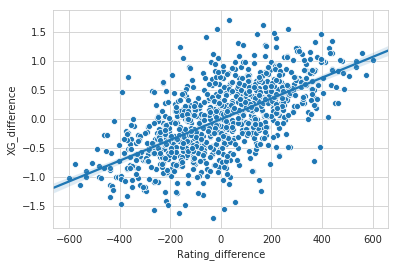

In [5]:
with sns.axes_style("whitegrid"):
    ax = sns.scatterplot(data=df_test,x='Rating_difference',y='XG_difference')

    scatterplot=sns.regplot(data=df_test,x='Rating_difference',y='XG_difference', scatter=False, ax=ax)
    fig = scatterplot.get_figure() 
    #fig.savefig("XG_diff_vs_rating_diff.png") 

In [6]:
##Normality test
from scipy import stats
elo_diff = df_test.loc[(df_test['Team_A']=='Brazil')
                             &(df_test['Team_B']=='Ecuador'),'Rating_difference'].values

x  = df_test.loc[(df_test['Rating_difference']<=max(0,elo_diff[0]))&
                (df_test['Rating_difference']>=min(0,elo_diff[0])),'XG_difference']
k2, p = stats.normaltest(x)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

p = 0.0135863
The null hypothesis cannot be rejected


In [7]:
##Utilities Functions

def compute_XG_diff_mean_std(dataframe,equipe1,equipe2,bound=0.25):
    """
    Computing the XG difference between equipe1 and equipe2
    By sampling mean and standard deviation from a subset of dataframe
    (Hypothesis : The XG_differences between teams with about the same elo ratings follow a normal law)
    """
    if equipe1 == equipe2:
        return("Error : same team")
    elo_diff = dataframe.loc[(dataframe['Team_A']==equipe1)
                             &(dataframe['Team_B']==equipe2),'Rating_difference'].values
    #Predict XG_difference :
    #mean = model.predict(elo_diff.reshape(-1, 1) 
    #changer interval autour duquel on sample XG_difference
    #print(elo_diff)
    sample = dataframe.loc[(dataframe['Rating_difference']<=max(elo_diff[0]*(1+bound),elo_diff[0]*(1-bound)))&
                      ( dataframe['Rating_difference']>=min(elo_diff[0]*(1+bound),elo_diff[0]*(1-bound))),'XG_difference']
    mean = sample.mean()
    variance  =sample.std()
    #print(mean,variance)
    return(mean,variance)

#Ajouter champ meilleur joeur, XG_meilleur_joueur et blessure 
#A chaque match on tire au hasard un dé pour savir si reisque de blessure
#si oui on retire les XG joueur au XG_equipe
class Team:
    def __init__(self, team_name,XG ,elo_ranking):
            self.name = team_name
            self.xg = XG
            self.elo_ranking = elo_ranking
            self.results = {"Win":0,"Draw":0,"Loss":0,"Goals":0,"Goals_Against":0,"Points":0}
    def __str__(self):
        return(f"Team {self.name}: \n XG : {self.xg} \n ELO Ranking : {self.elo_ranking} \n Current Results : {self.results}")

#rajouter champa data ou fonction compute ? 
class Match:
    def __init__(self, team_A, team_B,dataframe, is_round_robin):
        self.team_A = team_A
        self.team_B = team_B
        res = compute_XG_diff_mean_std(dataframe, team_A.name, team_B.name,bound=0.25)
       # print(res)
        self.diff_xg_mean , self.diff_xg_std = res[0],res[1]
        self.is_round_robin = is_round_robin
        self.winner = None
        #probabilities of W/D/L
        self.results = [0,0,0]
       # self.play_match()

    def simulate_match(self,N_samples):
        #Computing Elo Ranking difference
        #Predict XG_difference :
        #do multiple sampling?
        XG_difference = np.random.normal(loc=self.diff_xg_mean, scale=self.diff_xg_std)
        #print(XG_difference)
        #changing Xg_difference by  weighting more recent matchs and select only ranking teams accordingly_adversaries
        new_XG_team_A, new_XG_team_B =max(0,self.team_A.xg+XG_difference/2),max(0,self.team_B.xg-XG_difference/2)
        
        #Simulate 100000 matchs :
        simul_results =[[np.random.poisson(new_XG_team_A), np.random.poisson(new_XG_team_B)]for i in range(N_samples)]
    
        self.results = [np.mean([ score[0]>score[1] for score in simul_results]), 
                        np.mean([ score[0]==score[1] for score in simul_results]),
                       np.mean([ score[0]<score[1] for score in simul_results]) ]
       # print(   self.results)
        
        if np.argmax(self.results)== 0:
            if self.is_round_robin :
                self.team_A.results["Points"]+=3
                self.team_B.results["Points"]+=0
            self.team_A.results["Win"]+=1
            self.team_B.results['Loss']+=1
            self.winner = self.team_A
            
        elif np.argmax(self.results)== 2:
            if self.is_round_robin :
                self.team_A.results["Points"]+=0
                self.team_B.results["Points"]+=3
            self.team_A.results["Loss"]+=1
            self.team_B.results['Win']+=1
            self.winner = self.team_B
        else :
            if self.is_round_robin :
                self.team_A.results["Points"]+=1
                self.team_B.results["Points"]+=1
            elif not self.is_round_robin :
                ##Penaltuy shoothout 
                self.winner = np.random.choice([self.team_A,self.team_B])
            self.team_A.results["Draw"]+=1
            self.team_B.results['Draw']+=1
            
        #rajouter int?
        self.team_A.results['Goals']=  np.mean([ score[0] for score in simul_results])
        self.team_A.results['Goals_Against']= np.mean([ score[1] for score in simul_results])
        self.team_B.results['Goals']= np.mean([ score[1] for score in simul_results])
        self.team_B.results['Goals_Against']= np.mean([ score[0] for score in simul_results])
  
    def __str__(self):
        return (self.team_A.name + " probability of winning is " +str(100*self.results[0])+" % \n " +
        "Probability of Draw is "+str(100*self.results[1] )  +"%\n"+
        self.team_B.name + " probabilty of winning is " +str(100*self.results[2])+" %  ")

In [8]:
#tests
compute_XG_diff_mean_std(df_test,'Qatar','Senegal',bound=0.25)


(-0.053284382975286704, 0.5867956495884926)

In [9]:
Qatar = Team('Qatar', df_test.loc[df_test['Team_A']=='Qatar','score_A'].mode()[0],df_test.loc[df_test['Team_A']=='Qatar','Rating_A'].mode()[0])
Ecuador = Team('Ecuador', df_test.loc[df_test['Team_A']=='Ecuador','score_A'].mode()[0],df_test.loc[df_test['Team_A']=='Ecuador','Rating_A'].mode()[0])

print(Qatar)
print(Ecuador)
m = Match(Qatar,Ecuador,df_test,True ).simulate_match(10000)

Team Qatar: 
 XG : 1.710144927536232 
 ELO Ranking : 1680 
 Current Results : {'Win': 0, 'Draw': 0, 'Loss': 0, 'Goals': 0, 'Goals_Against': 0, 'Points': 0}
Team Ecuador: 
 XG : 1.28 
 ELO Ranking : 1833 
 Current Results : {'Win': 0, 'Draw': 0, 'Loss': 0, 'Goals': 0, 'Goals_Against': 0, 'Points': 0}


In [10]:
print(m)
print(Qatar)
print(Ecuador)

None
Team Qatar: 
 XG : 1.710144927536232 
 ELO Ranking : 1680 
 Current Results : {'Win': 0, 'Draw': 0, 'Loss': 1, 'Goals': 1.355, 'Goals_Against': 1.6382, 'Points': 0}
Team Ecuador: 
 XG : 1.28 
 ELO Ranking : 1833 
 Current Results : {'Win': 1, 'Draw': 0, 'Loss': 0, 'Goals': 1.6382, 'Goals_Against': 1.355, 'Points': 3}


In [11]:
# The winner of the group stage is obtained from
# 1 - points
# 2 - goal difference
# 3 - goal scored
# 4 - Random Sample      
class Group_Stage:
    def __init__(self, teams):
        self.first_qualified = None
        self.second_qualified = None
        self.teams = teams
       # self.reset()
       # self.play_first_stage()
        #inclure champ data ?

    def reset(self):
        for team in self.teams:
            self.results = {"Win":0,"Draw":0,"Loss":0,"Goals":0,"Goals_Against":0,"Points":0}

    def play_group_stage(self,dataframe):
        for i in range(0, len(self.teams)):
            for j in range(i + 1, len(self.teams)):
                #rajouter elo_diff_min et elo_std
                    #Match(self.teams[i], self.teams[j],np.random.normal(0,2),np.random.rand(), True).simulate_match(10000)
                    
                    Match(self.teams[i], self.teams[j],dataframe, True).simulate_match(10000)
        #Sorting the teamns           

        self.teams.sort(key= lambda elem : (elem.results['Points'],elem.results['Goals']-elem.results['Goals_Against'],elem.results['Goals'],
                                            np.random.rand()) ,reverse=True)
        self.first_qualified = self.teams[0]
        self.second_qualified = self.teams[1]
      #  [print(x) for x in self.teams]

In [12]:
Qatar = Team('Qatar', df_test.loc[df_test['Team_A']=='Qatar','score_A'].mode()[0],
             df_test.loc[df_test['Team_A']=='Qatar','Rating_A'].mode()[0])
Ecuador = Team('Ecuador', df_test.loc[df_test['Team_A']=='Ecuador','score_A'].mode()[0],
               df_test.loc[df_test['Team_A']=='Ecuador','Rating_A'].mode()[0])
Netherlands = Team('Netherlands', df_test.loc[df_test['Team_A']=='Netherlands','score_A'].mode()[0],
                   df_test.loc[df_test['Team_A']=='Netherlands','Rating_A'].mode()[0])
Senegal = Team('Senegal', df_test.loc[df_test['Team_A']=='Senegal','score_A'].mode()[0],
               df_test.loc[df_test['Team_A']=='Senegal','Rating_A'].mode()[0])


Group_A = Group_Stage([Qatar,Ecuador,Netherlands,Senegal])
Group_A.reset()
Group_A.play_group_stage(df_test)

In [13]:
print(Group_A.first_qualified, Group_A.second_qualified)

Team Netherlands: 
 XG : 2.230769230769231 
 ELO Ranking : 2040 
 Current Results : {'Win': 3, 'Draw': 0, 'Loss': 0, 'Goals': 2.4781, 'Goals_Against': 1.2072, 'Points': 9} Team Qatar: 
 XG : 1.710144927536232 
 ELO Ranking : 1680 
 Current Results : {'Win': 2, 'Draw': 0, 'Loss': 1, 'Goals': 2.0938, 'Goals_Against': 1.015, 'Points': 6}


In [14]:
m_elimination = Match(Netherlands,Senegal,df_test,False)
m_elimination.simulate_match(10000)

In [15]:
print(m_elimination)

Netherlands probability of winning is 69.72 % 
 Probability of Draw is 16.71%
Senegal probabilty of winning is 13.569999999999999 %  


In [16]:
print(m_elimination.winner)

Team Netherlands: 
 XG : 2.230769230769231 
 ELO Ranking : 2040 
 Current Results : {'Win': 4, 'Draw': 0, 'Loss': 0, 'Goals': 2.5897, 'Goals_Against': 1.0867, 'Points': 9}


In [17]:
Match(Netherlands,Senegal,df_test,False).simulate_match(1000).winner

AttributeError: 'NoneType' object has no attribute 'winner'

In [26]:
#Integrer calculmean_std dans match
class Tournament :
    def __init__(self,dataframe,groups_list):
        #dictionary {team_name str : team Team Object}
        self.all_teams = { team : Team(team, dataframe.loc[dataframe['Team_A']==team,'score_A'].mode()[0],
         dataframe.loc[dataframe['Team_A']==team,'Rating_A'].mode()[0] ) for team in dataframe['Team_A'].unique()}
        self.groups = groups_list
        self.data = dataframe
       
                            
    def main(self):
        winners = {}
        for i in range(0, 50):
            # Play round robin
            Groups =[]
            for group in  self.groups :
                #print(group)
                Group_g = Group_Stage([ self.all_teams[teams_group] for teams_group in group])
                Group_g.reset()
                Group_g.play_group_stage(self.data )  
                Groups.append(Group_g)

            # Play final elimination  phase 
           
            huitiemes = [(Match(Groups[2*i].first_qualified,Groups[2*i+1].second_qualified,
                                self.data,
                                False ),
                          Match(Groups[2*i].second_qualified,Groups[2*i+1].first_qualified,self.data ,False))
                         for i in range(int(len(self.groups)/2))]
            #print("8 emes: /n ",[(x[0].team_A.name,x[0].team_B.name,x[1].team_A.name,x[1].team_B.name )for x in huitiemes])
            [(x[0].simulate_match(10000),x[1].simulate_match(10000)) for x in  huitiemes ]
            

            # Quarters
          #  print(huitiemes)
            quarters = [Match(quart_finalist[0].winner,quart_finalist[1].winner,self.data,False ) for quart_finalist in huitiemes ]
          #  print("Quarts : /n ",[(x.team_A.name,x.team_B.name) for x in quarters])
          
            [x.simulate_match(10000) for x in   quarters ]
           # print([print(x.winner) for x in quarters])
            
            # Semifinals
           # print(int(len(quarters)/2))
           # print(len(quarters))
            #int(len(quarters)/2
            #semis = [Match(quarters[i].winner,quarters[i+1].winner ,self.data,False) for i in range(2)]
            semis = [Match(quarters[0].winner,quarters[1].winner,self.data,False ),
                    Match(quarters[2].winner,quarters[3].winner,self.data,False) ]
            #print("Demis : /n ",[(x.team_A.name,x.team_B.name) for x in semis])
            [x.simulate_match(10000) for x in  semis ]
            #print([print(x.winner) for x in semis])
            # Final
            winner_final = Match(semis[0].winner ,semis[1].winner,self.data, False)
            winner_final .simulate_match(10000)
            winner =winner_final.winner

            if winner.name in winners.keys():
                winners[winner.name] += 1
            else:
                winners[winner.name] = 1

        for key in sorted(winners, key=winners.get, reverse=True):
            print (key + ": " + str(winners[key]))
        return(winners)

In [27]:
t = Tournament(df_test,[
              ['Qatar','Netherlands' ,'Senegal','Ecuador'],
              ['England','United States','Iran','Wales'],
              ['Argentina','Poland','Mexico','Saudi Arabia'],
              ['France','Denmark','Tunisia','Australia'],
              ['Spain','Japan','Germany','Costa Rica'],
              ['Belgium','Croatia','Morocco','Canada'],
              ['Brazil','Switzerland','Serbia','Cameroon'],
              ['Portugal','Uruguay','South Korea','Ghana']])

In [28]:
res = t.main()

Brazil: 16
Belgium: 11
Netherlands: 6
France: 6
Canada: 3
England: 2
Spain: 2
Argentina: 2
Portugal: 1
Germany: 1


In [33]:
type(res)

dict

In [34]:
pd.DataFrame(res.items(), columns=['Country', 'Wins'])

,Country,Wins
0,Belgium,11
1,Brazil,16
2,Netherlands,6
3,Canada,3
4,France,6
5,Portugal,1
6,England,2
7,Spain,2
8,Argentina,2
9,Germany,1


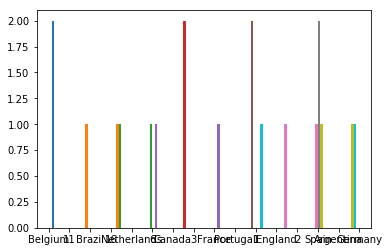

In [41]:
import matplotlib.pyplot as plt
plt.hist(res.items());

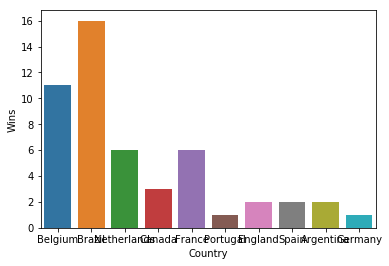

In [43]:
df = pd.DataFrame(res.items(), columns=['Country', 'Wins'])
sns.barplot(data=df, x="Country", y="Wins")